In [2]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from swdf.preprocessing import BackForwardFillMissing

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Forecast Dst

> 6- day horizon, hourly based

In [3]:
cwd = os.getcwd()
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geo = yaml2dict('./config/dst.yaml', attrdict=True)
config_geo = config_geo.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_geo})
# Add the architecture config
if config.arch_config_file is not None:
    config.arch_config_file = Path(config.arch_config_file)
    if config.arch_config_file.exists():
        config.arch = yaml2dict(config.arch_config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch_config_file}')
        config.arch = AttrDict()
else:
    config.arch = AttrDict()
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': Path('config/patchtst.yaml'),
  'arch_name': 'PatchTST',
  'bs': 1024,
  'deltaHL': 2.0,
  'dst': {'data_path': '../data/DST_IAGA2002.txt', 'download': False},
  'horizon': 144,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 432,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.001,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [4]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'arch_name': 'PatchTST', 'arch_config_file': Path('config/patchtst.yaml'), 'bs': 1024, 'horizon': 144, 'init_weights': False, 'lookback': 432, 'lr_max': None, 'n_epoch': 30, 'partial_n': 0.001, 'seed': 42, 'test_start_datetime': '2012-10-01 12:00:00', 'test_end_datetime': '2018-12-31 12:00:00', 'valid_start_datetime': '2018-01-01 12:00:00', 'deltaHL': 2.0, 'is_optuna_study': False, 'wandb': {'enabled': False, 'log_learner': True, 'mode': 'offline', 'group': None, 'project': 'swdf'}, 'add_time_channels': False, 'dst': {'download': False, 'data_path': '../data/DST_IAGA2002.txt'}, 'arch': {'decomposition': True, 'individual': True, 'padding_patch': True, 'revin': True}}


In [5]:
fname = config.dst.data_path if not config.dst.download else download_dst_data(save_folder="../data")
fname

'../data/DST_IAGA2002.txt'

In [6]:
from io import StringIO

def filter_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    filtered_lines = [line for line in lines if not line.strip().endswith('|')]
    return ''.join(filtered_lines)

filtered_data = filter_lines(fname) 

# Use StringIO to simulate a file object
data_io = StringIO(filtered_data)

with open("../data/output_dst.txt", 'w') as file:
    file.write(filtered_data)

# Read the cleaned data into a DataFrame
df_dst_raw = pd.read_csv(data_io,
                 comment='#',  # Skip lines starting with '#'
                 delim_whitespace=True,  # Since your columns are separated by whitespace
                 names=['DATE', 'TIME', 'DOY', 'DST'],  # Assign column names manually
                 dtype={'DOY': int, 'DST': float},  # Specify data types for columns
                 na_values='99999.99'
            )

# Combine 'DATE' and 'TIME' into a single 'DateTime' column
df_dst_raw['Datetime'] = pd.to_datetime(df_dst_raw['DATE'] + ' ' + df_dst_raw['TIME'])

# Optionally, drop the original 'DATE' and 'TIME' columns if they are no longer needed
df_dst_raw.drop(columns=['DATE', 'DOY', 'TIME'], inplace=True)
df_dst_raw

,DST,Datetime
0,11.0,1957-01-01 00:00:00
1,13.0,1957-01-01 01:00:00
2,12.0,1957-01-01 02:00:00
3,12.0,1957-01-01 03:00:00
4,9.0,1957-01-01 04:00:00
...,...,...
594643,NaN,2024-08-31 19:00:00
594644,NaN,2024-08-31 20:00:00
594645,NaN,2024-08-31 21:00:00
594646,NaN,2024-08-31 22:00:00


Format of the Dst data file (WDC format)

| Column | Format | Short Description                                      |
|--------|--------|--------------------------------------------------------|
| 1-3    | A3     | Index name 'DST'                                       |
| 4-5    | I2     | The last two digits of the year                        |
| 6-7    | I2     | Month                                                  |
| 8      | A1     | '*' for index                                          |
| 9-10   | I2     | Date                                                   |
| 11-12  | A2     | All spaces or may be "RR" for quick look               |
| 13     | A1     | 'X' (for index)                                        |
| 14     | A1     | Version (0: quicklook, 1: provisional, 2: final, 3 and up: corrected final or may be space) |
| 15-16  | I2     | Top two digits of the year (19 or space for 19XX, 20 from 2000) |
| 17-20  | I4     | Base value, unit 100 nT                                |
| 21-116 | 24I4   | 24 hourly values, 4 digit number, unit 1 nT, value 9999 for the missing data. First data is for the first hour of the day, and Last data is for the last hour of the day. |
| 117-120| I4     | Daily mean value, unit 1 nT. Value 9999 for the missing data. |


Format of the Dst Data file (IAGA-2002): 
https://wdc.kugi.kyoto-u.ac.jp/mdplt/format/iaga2002.html

To process the file, as given by the Kyoto provider, I used this awek script:
```
awk '!/^DATE/ && !/^ /' input.txt > output.txt
```

In [7]:
# Check if there are any missing values
df_dst_raw.isna().sum()

DST         591
Datetime      0
dtype: int64

In [8]:
# Distinct value of the column DST (classification problem?)
df_dst_raw.DST.unique().__len__()

441

In [9]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('fill_missing', BackForwardFillMissing(['DST'])), # fill missing data (1st ffill. 2nd value=0)
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_dst_raw)
df

[Pipeline] ...... (step 1 of 2) Processing fill_missing, total=   0.0s
Initial memory usage: 13.60 MB  
Final memory usage  : 11.33 MB   (-16.7%)
[Pipeline] .......... (step 2 of 2) Processing shrinker, total=   0.0s


,DST,Datetime
0,11.0,1957-01-01 00:00:00
1,13.0,1957-01-01 01:00:00
2,12.0,1957-01-01 02:00:00
3,12.0,1957-01-01 03:00:00
4,9.0,1957-01-01 04:00:00
...,...,...
594052,-16.0,2024-08-07 04:00:00
594053,-15.0,2024-08-07 05:00:00
594054,-13.0,2024-08-07 06:00:00
594055,-8.0,2024-08-07 07:00:00


In [10]:
df.isna().sum()

DST         0
Datetime    0
dtype: int64

In [11]:
save_object(df, "./preprocessed_data/dataframes/dst.pkl")

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/dst.pkl


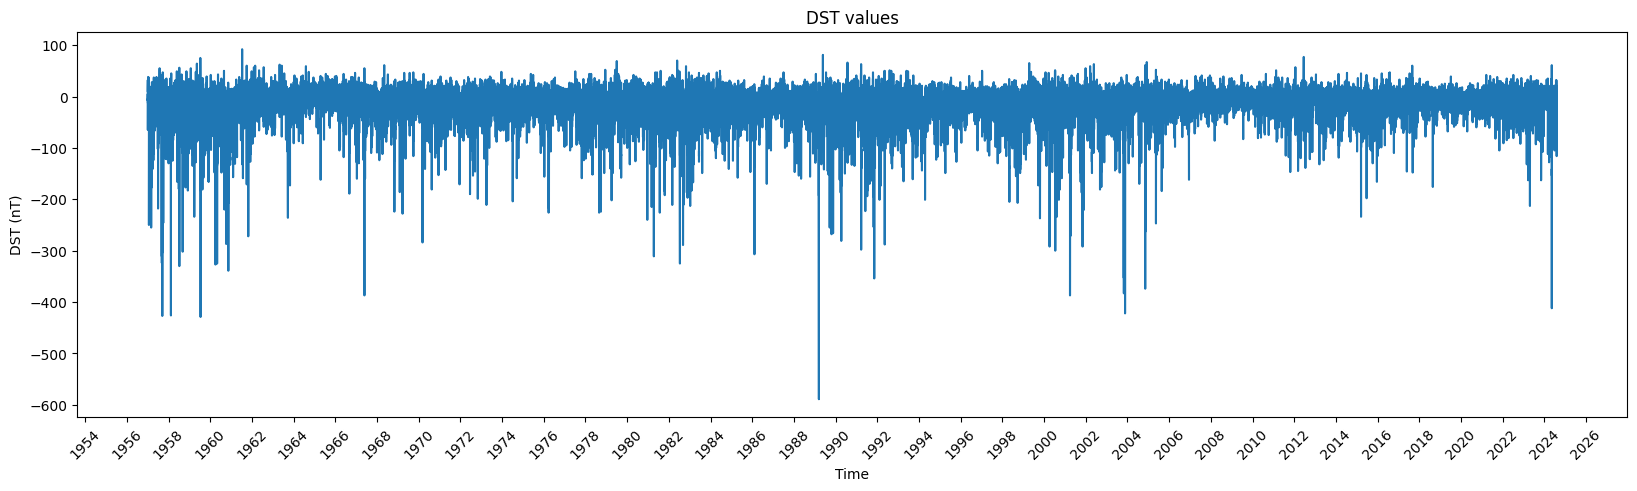

In [10]:
# hide

# Plot the DST values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.Datetime, df_dst_raw.DST)
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

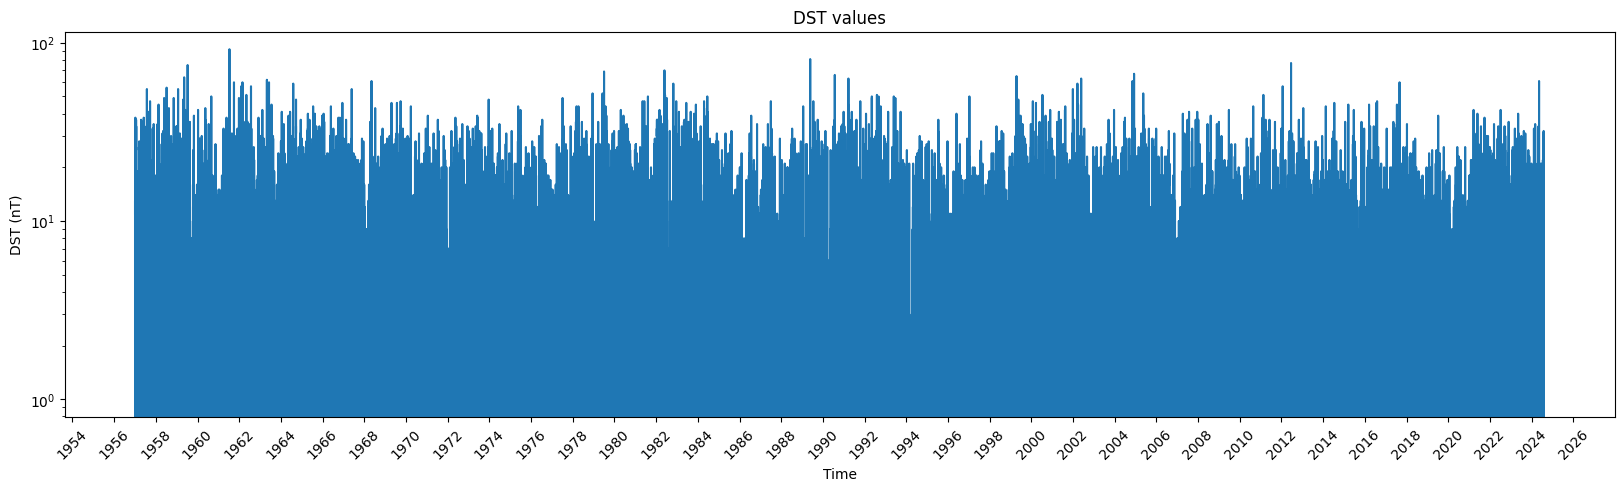

In [11]:
# hide

# Plot the DST values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.Datetime, df_dst_raw.DST)
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')
ax.set_yscale('log')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()


In [12]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

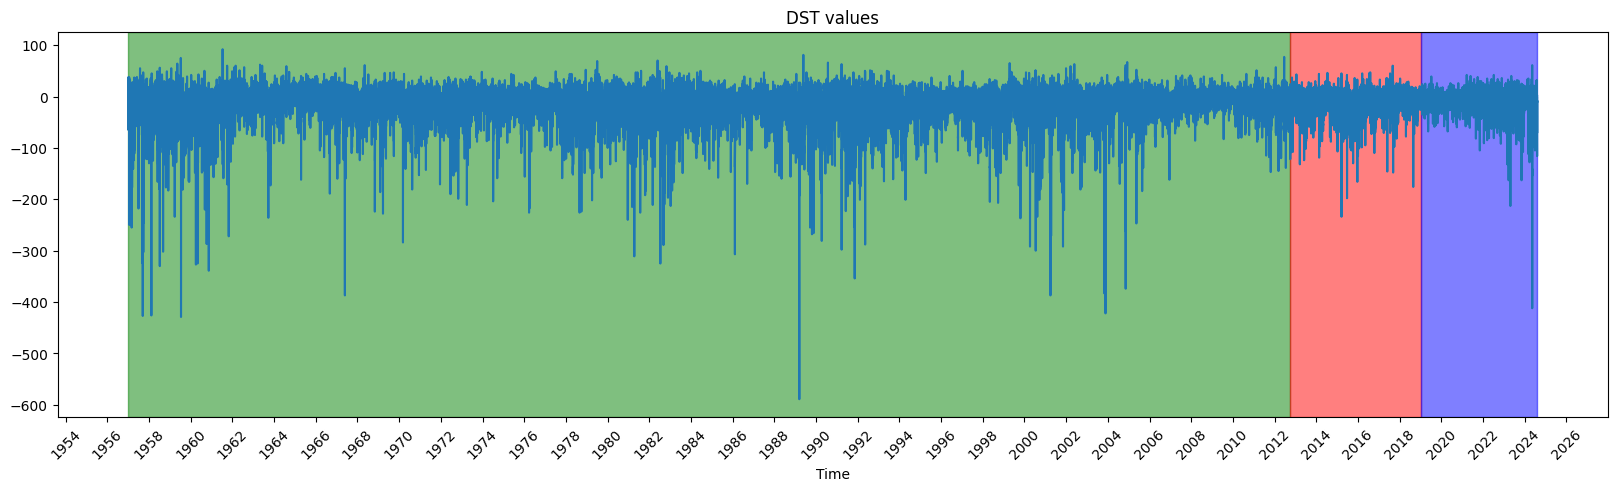

In [13]:
# hide

# Plot the variable DST, covering the different periods (training, test and validation)
# with different colors.
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.Datetime, df.DST)
ax.axvspan(df.Datetime.min(), test_start_datetime, alpha=0.5, color='green')
ax.axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
ax.axvspan(test_end_datetime, df.Datetime.max(), alpha=0.5, color='blue')
ax.set_title('DST values')
ax.set_xlabel('Time')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

In [14]:
# Splits: same as in solar flux (solfsmy) notebook

splits_ = get_forecasting_splits(df[df.Datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='Datetime')
foo = df[df.Datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#489614) [0,1,2,3,4,5,6,7,8,9...],
 (#57262) [536220,536221,536222,536223,536224,536225,536226,536227,536228,536229...],
 (#45888) [489757,489758,489759,489760,489761,489762,489763,489764,489765,489766...])

In [15]:
# Add or not add the time features
data_columns_fcst = ['DST']
data_columns_time = ['DOY']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst
data_columns

['DST']

In [16]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')
# TODO: I don't know why but if I don't copy the dataframe df it gets modified
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)
#df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.2s


,DST,Datetime
0,1.104087,1957-01-01 00:00:00
1,1.187048,1957-01-01 01:00:00
2,1.145567,1957-01-01 02:00:00
3,1.145567,1957-01-01 03:00:00
4,1.021125,1957-01-01 04:00:00


In [17]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, fcst_horizon=config.horizon, 
                                x_vars=data_columns, y_vars=data_columns_fcst)
X.shape, y.shape

((593482, 1, 432), (593482, 1, 144))

### Train

3.0199516913853586e-05
#params: 20645160


epoch,train_loss,valid_loss,time
0,655.752625,304.283325,00:19
1,698.740479,294.881653,00:19
2,656.630249,295.484314,00:19
3,665.530029,322.705444,00:19
4,681.952759,317.630432,00:19
5,685.632690,338.547729,00:19
6,693.759583,466.617188,00:19
7,696.588928,514.140991,00:19
8,707.802246,591.767517,00:19
9,719.202515,466.419403,00:19


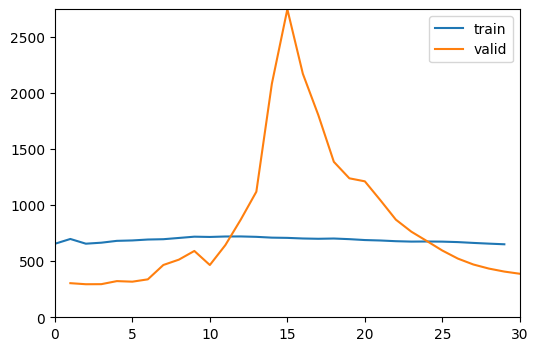

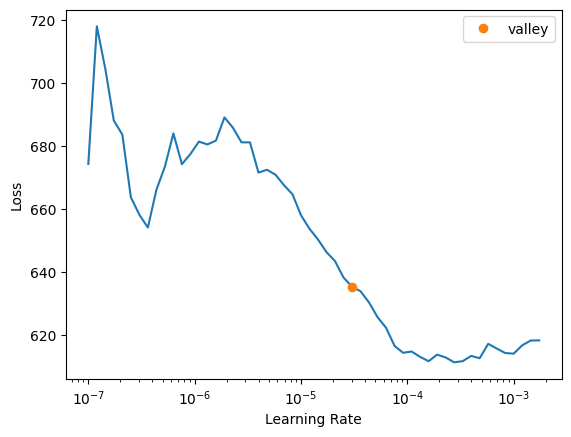

In [20]:
from swdf.losses import MSELoss

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     loss_func=MSELoss(reduction='mean'),
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
print(lr_max)
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)

In [21]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

388.26995849609375
Stored 'valid_loss' (float)


In [22]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

446.4754333496094


In [23]:
# Save everything
# learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path='tmp', verbose=True) 
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact('tmp', type='learner', name='Dst')
    

Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [24]:
if run is not None:
    run.finish()